# Higgs Boson Analysis with ATLAS Open Data
This is an example analysis of the Higgs boson detection via the decay channel H &rarr; ZZ* &rarr; 4l  
From the decay products measured at the ATLAS experiment and provided as open data, you will be able to produce a histogram, and from there you can infer the invariant mass of the Higgs boson.  
Code: it is based on the original work at [ATLAS outreach notebooks](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/tree/master/13-TeV-examples/uproot_python)  
Data: from the 13TeV [ATLAS opendata](http://opendata.atlas.cern/release/2020/documentation/datasets/files.html)  
Physics: See ATLAS paper on the [discovery of the Higgs boson](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1) 

See also: https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics  

Author and contact: Luca.Canali@cern.ch  
March, 2022

## H &rarr; ZZ* &rarr; 4l analsys with extra cuts, using Monte Carlo simulation data

In [1]:
# Run this if you need to install Apache Spark (PySpark)

# !pip install pyspark

# Install sparkhistogram
# Note: if you cannot install the package, create the computeHistogram
# function as detailed at the end of this notebook.

!pip install sparkhistogram

In [ ]:
# Run this to download the dataset 
# It is a small file (81 MB), this exercise is meant mostly to show the Spark API
# See further details at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

!wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/ATLAS_Higgs_opendata/MC_signal_4lep.parquet

In [ ]:
# Start the Spark Session
# This uses local mode for simplicity
# the use of findspark is optional

# import findspark
# findspark.init("/home/luca/Spark/spark-3.3.0-bin-hadoop3")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("H_ZZ_4Lep")
         .master("local[*]")
         .getOrCreate()
        )

In [3]:
# Read data from Monte Carlo simulation

# customize depending on how where you downloaded the datasets
data_dir = "./"

df_events = spark.read.parquet(data_dir + "MC_signal_4lep.parquet")

df_events.printSchema()


root
 |-- runNumber: integer (nullable = true)
 |-- eventNumber: integer (nullable = true)
 |-- channelNumber: integer (nullable = true)
 |-- mcWeight: float (nullable = true)
 |-- scaleFactor_PILEUP: float (nullable = true)
 |-- scaleFactor_ELE: float (nullable = true)
 |-- scaleFactor_MUON: float (nullable = true)
 |-- scaleFactor_PHOTON: float (nullable = true)
 |-- scaleFactor_TAU: float (nullable = true)
 |-- scaleFactor_BTAG: float (nullable = true)
 |-- scaleFactor_LepTRIGGER: float (nullable = true)
 |-- scaleFactor_PhotonTRIGGER: float (nullable = true)
 |-- trigE: boolean (nullable = true)
 |-- trigM: boolean (nullable = true)
 |-- trigP: boolean (nullable = true)
 |-- lep_n: long (nullable = true)
 |-- lep_truthMatched: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- lep_trigMatched: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- lep_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- le

In [4]:
# Count the number of events before cuts (filter)
print(f"Number of events: {df_events.count()}")

Number of events: 385706


In [5]:
df_lep = df_events.selectExpr("""arrays_zip(lep_type, lep_charge, lep_E, lep_pt, lep_phi, lep_eta, lep_z0,
                                 lep_etcone20, lep_ptcone30, lep_trackd0pvunbiased, lep_tracksigd0pvunbiased) lep
                          """,)
df_lep.filter("size(lep) == 4").count()

378760

In [6]:
# filter electrons and muons inside the lepton array

df_lep_filtered = df_lep.selectExpr("""filter(lep, l ->
                         (l.lep_type = 11
                          and l.lep_pt > 7000.0
                          and abs(l.lep_eta) < 2.4
                          and l.lep_etcone20/l.lep_pt < 0.3
                          and l.lep_ptcone30/l.lep_pt < 0.3
                          and abs(l.lep_trackd0pvunbiased) / l.lep_tracksigd0pvunbiased < 5
                          and l.lep_z0 * sin (2 * atan(exp(-l.lep_eta)))  < 0.5
                         )
                         or 
                         (l.lep_type = 13
                          and l.lep_pt > 5000.0
                          and abs(l.lep_eta) < 2.5
                          and l.lep_etcone20/l.lep_pt < 0.3
                          and l.lep_ptcone30/l.lep_pt < 0.3
                          and abs(l.lep_trackd0pvunbiased) / l.lep_tracksigd0pvunbiased < 3
                          and l.lep_z0 * sin (2 * atan(exp(-l.lep_eta)))  < 0.5
                         )
                       ) as lep""")


df_lep_filtered.filter("size(lep) == 4").count()

333373

### Apply cuts
More details on the cuts (filters applied to the event data) in the reference ATLAS paper on the [discovery of the Higgs boson](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1) 

In [7]:
# Apply filters to the input data

# only events with 4 leptons in the input data
df_lep_filtered = df_lep_filtered.filter("size(lep) == 4")

# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"

# cut on lepton charge
df_lep_filtered = df_lep_filtered.filter("lep.lep_charge[0] + lep.lep_charge[1] + lep.lep_charge[2] + lep.lep_charge[3] == 0")

# cut on lepton type
df_lep_filtered = df_lep_filtered.filter("lep.lep_type[0] + lep.lep_type[1] + lep.lep_type[2] + lep.lep_type[3] in (44, 48, 52)")

print(f"Number of events after applying cuts: {df_lep_filtered.count()}")

Number of events after applying cuts: 324073


In [8]:
# order leptons by pt, highest values first
df_lep_ordered = df_lep_filtered.selectExpr("""array_sort(lep, (left, right) -> 
       case when left.lep_pt > right.lep_pt then -1 
            when left.lep_pt < right.lep_pt then 1
            else 0 end) as lep""")

In [9]:
# filter based on the ordered lepton list
# filter values accoring to the analysis paper

df_lep_ordered_filtered = df_lep_ordered.filter("""
     lep.lep_pt[0] > 20000.0
     and lep.lep_pt[1] > 15000.0
     and lep.lep_pt[2] > 10000.0
""")

df_lep_ordered_filtered.count()

316323

In [10]:
df_lep_ordered_filtered.selectExpr("lep.lep_type", "lep.lep_pt").show(5, False)

+----------------+--------------------------------------------+
|lep_type        |lep_pt                                      |
+----------------+--------------------------------------------+
|[13, 13, 13, 13]|[51905.457, 41248.57, 16397.67, 7471.2275]  |
|[13, 13, 13, 13]|[41430.645, 40307.168, 16133.789, 7481.8574]|
|[13, 11, 11, 13]|[33646.71, 27313.271, 20035.95, 16472.64]   |
|[13, 11, 13, 11]|[77118.56, 27845.74, 17726.541, 14714.521]  |
|[11, 11, 11, 11]|[161909.22, 53367.754, 25596.69, 18864.479] |
+----------------+--------------------------------------------+
only showing top 5 rows



### Further cuts

Paper: The same-flavour and opposite-charge lepton pair with an invariant mass closest to the Z boson mass ($m_Z$) in the quadruplet is referred to as the leading lepton pair. Its invariant mass, denoted by $m_{12}$ , is required to be between 50 GeV and 106 GeV.  
The remaining same-flavour, opposite-charge lepton pair is the sub-leading lepton pair. Its invariant mass, $m_{34}$, is required to be in the range $m_{min} < m_{34} < 115 GeV$, where the value of mmin depends on the reconstructed four-lepton invariant mass, $m_{4l}$.  
The value of $m_{min}$ varies monotonically from 17.5 GeV at $m_{4l}$ = 120 GeV to 50 GeV at $m_{4l}$ = 190 GeV and is constant above this value.  
All possible lepton pairs in the quadruplet that have the same flavour and opposite charge must satisfy $m_{ll} > 5 GeV$ in order to reject backgrounds involving the production and decay of J/ψ mesons.

In [80]:
# To do: these extra cuts on leading and sub-leading pair are to be implemented..

### Compute the invariant mass
This computes the 4-vectors sum for the 4-lepton system
using formulas from special relativity.  
See also http://edu.itp.phys.ethz.ch/hs10/ppp1/2010_11_02.pdf
and https://en.wikipedia.org/wiki/Invariant_mass

In [11]:
# This computes the 4-vectors sum for the 4-lepton system

df_4lep = df_lep_filtered.selectExpr(
"lep.lep_pt[0] * cos(lep.lep_phi[0]) + lep.lep_pt[1] * cos(lep.lep_phi[1]) + lep.lep_pt[2] * cos(lep.lep_phi[2]) + lep.lep_pt[3] * cos(lep.lep_phi[3]) as Px",
"lep.lep_pt[0] * sin(lep.lep_phi[0]) + lep.lep_pt[1] * sin(lep.lep_phi[1]) + lep.lep_pt[2] * sin(lep.lep_phi[2]) + lep.lep_pt[3] * sin(lep.lep_phi[3]) as Py",
"lep.lep_pt[0] * sinh(lep.lep_eta[0]) + lep.lep_pt[1] * sinh(lep.lep_eta[1]) + lep.lep_pt[2] * sinh(lep.lep_eta[2]) + lep.lep_pt[3] * sinh(lep.lep_eta[3]) as Pz",
"lep.lep_E[0] + lep.lep_E[1] + lep.lep_E[2] + lep.lep_E[3] as E"  
)

df_4lep.show(5)

df_4lep_invmass = df_4lep.selectExpr("sqrt(E * E - ( Px * Px + Py * Py + Pz * Pz))/1e3 as invmass_GeV")

df_4lep_invmass.show(5)

+------------------+-------------------+------------------+---------+
|                Px|                 Py|                Pz|        E|
+------------------+-------------------+------------------+---------+
|-867.6994198619705|-2279.9000389946814|-99440.67452892396|157946.28|
|  8067.13079081967|-13.284619779517016|-92928.31530294346|147034.55|
|-1499.920452116341|-330.86533634722036| 50649.90713907084|135251.33|
| 89927.65860305948| 58032.758097137645|148712.28174206842| 221039.0|
|243065.92162896198| -26371.73737747334| -287895.814088867|397388.06|
+------------------+-------------------+------------------+---------+
only showing top 5 rows

+------------------+
|       invmass_GeV|
+------------------+
|122.68915751101063|
| 113.6591678276742|
|125.39996029333513|
|123.64510277758014|
| 123.5182389789679|
+------------------+
only showing top 5 rows



In [12]:
# This defines the DataFrame transformation to compute the histogram of invariant mass
# The result is a histogram with (energy) bin values and event counts foreach bin

# Requires sparkhistogram
# See https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_DataFrame_Histograms.md 
from sparkhistogram import computeHistogram

# histogram parameters
min_val = 80
max_val = 250
num_bins = (max_val - min_val) / 5.0

# use the helper function computeHistogram in the package sparkhistogram
histogram_data = computeHistogram(df_4lep_invmass, "invmass_GeV", min_val, max_val, num_bins) 


In [13]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 222 ms, sys: 29.3 ms, total: 252 ms
Wall time: 10.3 s


In [14]:
import numpy as np

# Computes statistical error on the data (histogram)
histogram_data_stat_errors = np.sqrt(histogram_data_pandas)

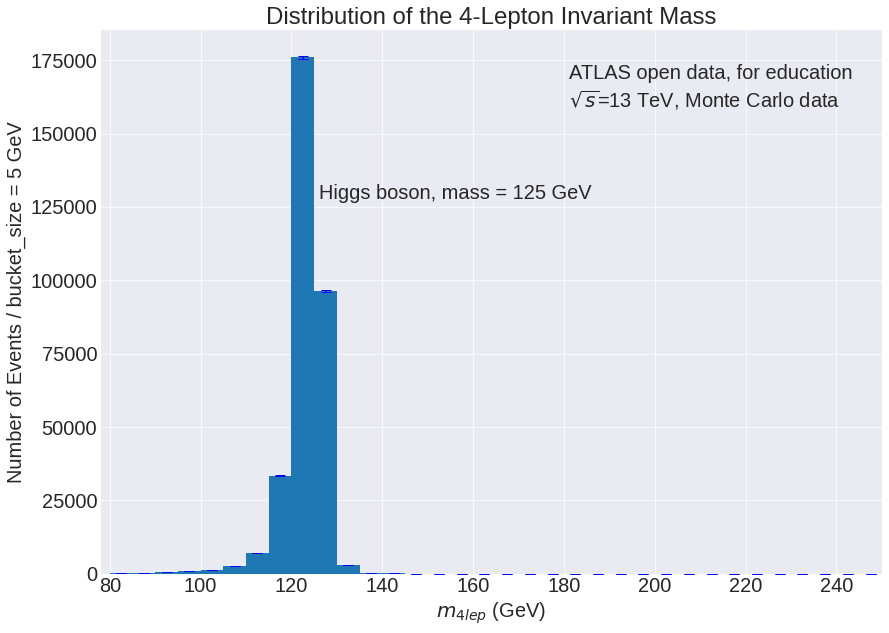

In [15]:
# This plots the data histogram with error bars

import matplotlib.pyplot as plt 

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

x = histogram_data_pandas["value"]
y = histogram_data_pandas["count"]
err = histogram_data_stat_errors["count"]

# scatter plot
#ax.plot(x, y, marker='o', color='red', linewidth=0)
#ax.errorbar(x, y, err, fmt = 'ro')
# histogram with error bars
ax.bar(x, y, width = 5.0, yerr = err, capsize = 5, linewidth = 0.4, ecolor='blue', fill=True)

ax.set_xlim(min_val-2, max_val)

ax.set_xlabel('$m_{4lep}$ (GeV)')
ax.set_ylabel('Number of Events / bucket_size = 5 GeV')
ax.set_title("Distribution of the 4-Lepton Invariant Mass")

# Label for the Z ang Higgs spectrum peaks
txt_opts = {'horizontalalignment': 'left',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

#plt.text(0.10, 0.86, "Z boson, mass = 91 GeV", **txt_opts)
plt.text(0.28, 0.70, "Higgs boson, mass = 125 GeV", **txt_opts)

# Add energy and luminosity
plt.text(0.60, 0.92, "ATLAS open data, for education", **txt_opts)
plt.text(0.60, 0.87, '$\sqrt{s}$=13 TeV, Monte Carlo data', **txt_opts)

plt.show()

In [16]:
spark.stop()

## Note on sparkhistogram

Use this to define the computeHistogram function if you cannot pip install sparkhistogram

In [ ]:
def computeHistogram(df: "DataFrame", value_col: str, min: float, max: float, bins: int) -> "DataFrame":
    """ This is a dataframe function to compute the count/frequecy histogram of a column
        
        Parameters
        ----------
        df: the dataframe with the data to compute
        value_col: column name on which to compute the histogram
        min: minimum value in the histogram
        max: maximum value in the histogram
        bins: number of histogram buckets to compute
        
        Output DataFrame
        ----------------
        bucket: the bucket number, range from 1 to bins (included)
        value: midpoint value of the given bucket
        count: number of values in the bucket        
    """
    step = (max - min) / bins
    # this will be used to fill in for missing buckets, i.e. buckets with no corresponding values
    df_buckets = spark.sql(f"select id+1 as bucket from range({bins})")
    
    histdf = (df
              .selectExpr(f"width_bucket({value_col}, {min}, {max}, {bins}) as bucket")
              .groupBy("bucket")
              .count()
              .join(df_buckets, "bucket", "right_outer") # add missing buckets and remove buckets out of range
              .selectExpr("bucket", f"{min} + (bucket - 1/2) * {step} as value", # use center value of the buckets
                          "nvl(count, 0) as count") # buckets with no values will have a count of 0
              .orderBy("bucket")
             )
    return histdf